# Chromatographic Analysis

In targeted proteomics, such as
[SRM](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-SRM)
/ MRM / PRM / DIA applications, groups of chromatograms need to be
analyzed frequently. OpenMS provides several powerful tools for analysis
of chromatograms. Most of them are part of the OpenSWATH suite of tools
and are also discussed in the [OpenSwath
documentation](https://www.openswath.org).

## Peak Detection

Here, we will focus on a simple example where two peptides are analyzed.
We will need 2 input files: the chromatogram files that contains the
chromatographic raw data (raw
[SRM](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-SRM)
traces or extracted ion chromatograms from PRM/DIA data) as well as the
library file used to generated the data which contains information about
the targeted peptides:

In [ ]:
from urllib.request import urlretrieve
import pyopenms as oms

gh = "https://raw.githubusercontent.com/OpenMS/pyopenms-docs/master"
urlretrieve(gh + "/src/data/OpenSwathAnalyzer_1_input_chrom.mzML", "chrom.mzML")
urlretrieve(
    gh + "/src/data/OpenSwathAnalyzer_1_input.TraML", "transitions.TraML"
)

chroms = oms.MSExperiment()
library = oms.TargetedExperiment()
oms.MzMLFile().load("chrom.mzML", chroms)
oms.TraMLFile().load("transitions.TraML", library)

# Investigate library
for t in library.getTransitions():
    print(
        "Transition",
        t.getNativeID(),
        "belongs to peptide group",
        t.getPeptideRef(),
    )

print(
    "Input contains",
    len(library.getTransitions()),
    "transitions and",
    len(chroms.getChromatograms()),
    "chromatograms.",
)
features = oms.FeatureMap()
dummy_trafo = oms.TransformationDescription()
dummy_exp = oms.MSExperiment()
oms.MRMFeatureFinderScoring().pickExperiment(
    chroms, features, library, dummy_trafo, dummy_exp
)
for f in features:
    print(
        "Feature for group",
        f.getMetaValue("PeptideRef"),
        "with precursor m/z",
        f.getMetaValue("PrecursorMZ"),
    )
    print(
        "  Feature found at RT =",
        f.getRT(),
        "with library dot product",
        f.getMetaValue("var_library_dotprod"),
    )

Here we see that for the first group of transitions (`tr_gr1`), a single
peak at retention time $3119\ seconds$ was found. However, for the
second group of transitions, two peaks are found at retention times
$3119\ seconds$ and at $3055\ seconds$.

## Visualization

We can confirm the above analysis by visual inspection of the
`chrom.mzML` file produced above in the
[TOPPView](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-TOPPView)
software:

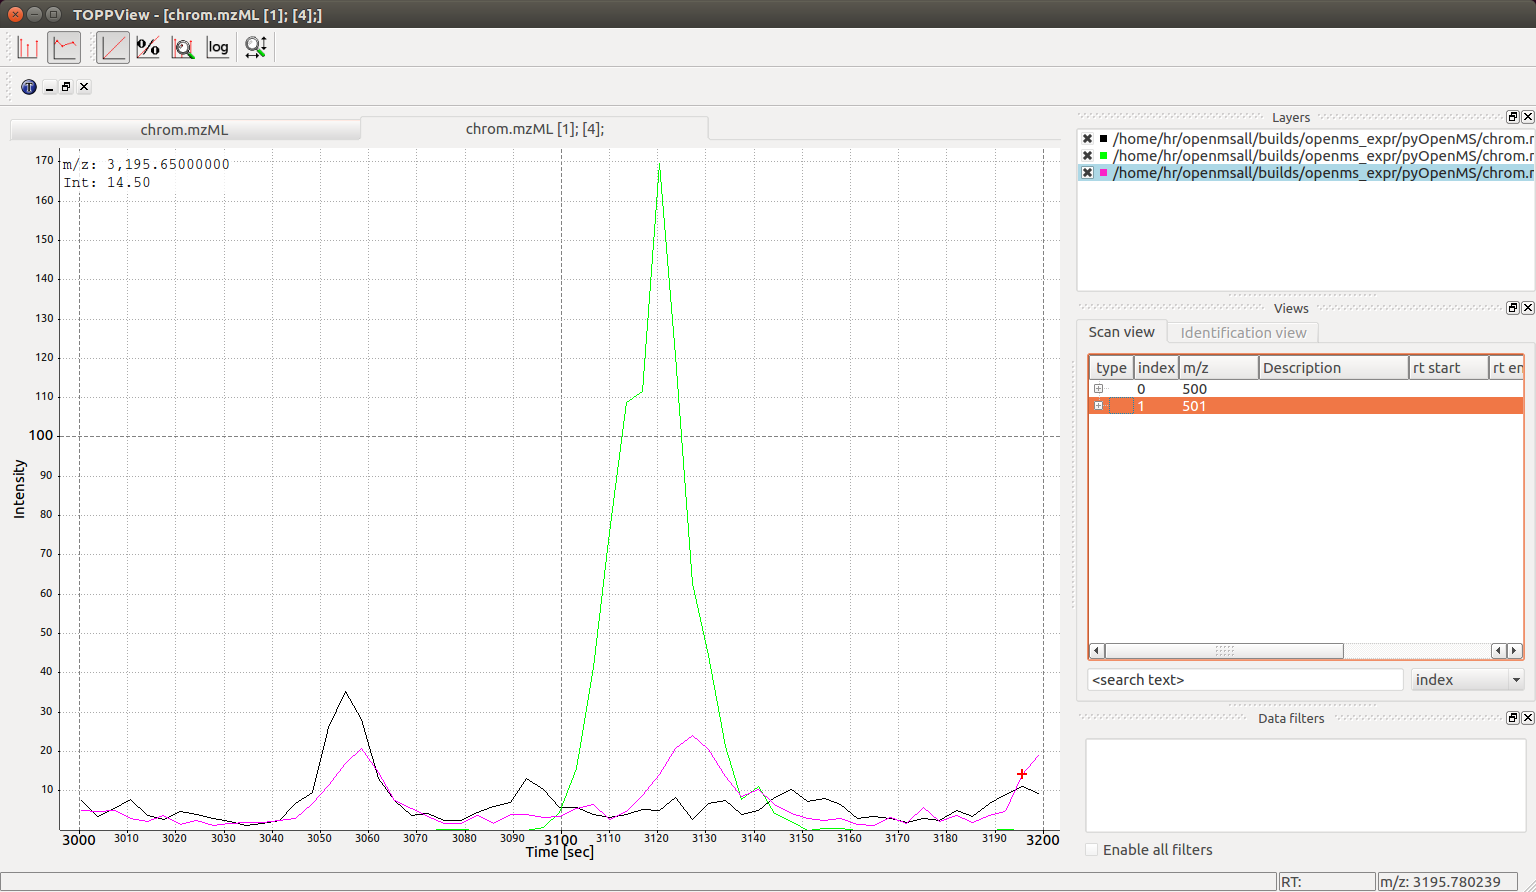

However, our output above contains more information than only retention
time:

``` output
Feature for group tr_gr1 with precursor m/z 500.0
  Feature found at RT = 3119.091968219877 with library dot product 0.9924204062692046
Feature for group tr_gr2 with precursor m/z 501.0
  Feature found at RT = 3055.584481870532 with library dot product 0.952054383474221
Feature for group tr_gr2 with precursor m/z 501.0
  Feature found at RT = 3119.0630105310684 with library dot product 0.7501676755451506  
```

Based on the output above, we can infer that the peak at $3055\ seconds$
is likely the correct peak for `tr_gr2` since it has a high library dot
product ($0.95$) while the peak at $3119\ seconds$ is likely incorrect
for `tr_gr2` since its dot product is low ($0.75$). We also see that a
peak at $3119\ seconds$ is likely correct for `tr_gr1` since it matches
well with the expected library intensities and has a high dot product
($0.99$).

Note: to get an overview over all available scores for a particular MRM
features `f`, you can use

In [ ]:
k = []
f.getKeys(k)
print(k)

## Smoothing

Now you may want to show the chromatograms to your collaborator, but you
notice that most software solutions smooth the chromatograms before
display. In order to provide smooth chromatograms, you can apply a
filter using pyOpenMS:

In [ ]:
sg = oms.SavitzkyGolayFilter()
sg.filterExperiment(chroms)
# MzMLFile().store("chrom.filter.mzML", chroms)

Which leads to the following smoothed chromatographic traces:

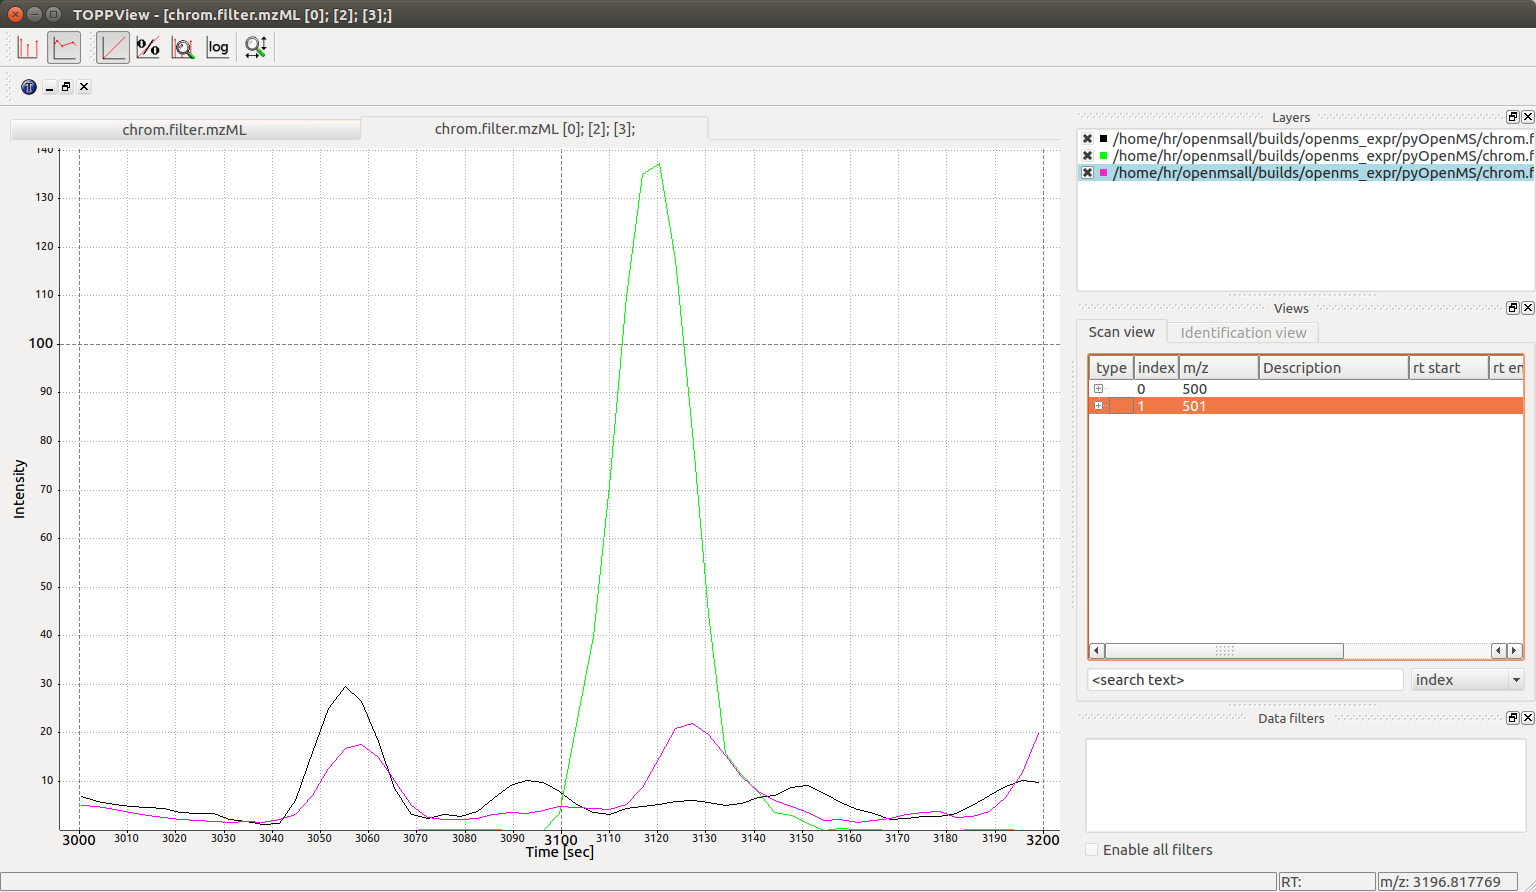